In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [3]:
df_orders = pd.read_csv('data/olist_orders_dataset.csv')
df_order_items = pd.read_csv('data/olist_order_items_dataset.csv')  
df_payments = pd.read_csv('data/olist_order_payments_dataset.csv')
df_customers = pd.read_csv('data/olist_customers_dataset.csv')
df_products = pd.read_csv('data/olist_products_dataset.csv')
df_sellers = pd.read_csv('data/olist_sellers_dataset.csv')
df_reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
df_geolocation = pd.read_csv('data/olist_geolocation_dataset.csv')
df_category_name_translation = pd.read_csv('data/product_category_name_translation.csv')

In [4]:
# gather all dataframes in a dictionary for easy access
all_dfs = {
    'orders': df_orders,
    'order_items': df_order_items,
    'payments': df_payments,
    'customers': df_customers,
    'products': df_products,
    'sellers': df_sellers,
    'reviews': df_reviews,
    'geolocation': df_geolocation,
    'category_translation': df_category_name_translation
}

In [5]:
# show all dict column 
for df_name, df in all_dfs.items():
    print(f"\nDataframe: {df_name}")
    print(list(df.columns))


Dataframe: orders
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

Dataframe: order_items
['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']

Dataframe: payments
['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']

Dataframe: customers
['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']

Dataframe: products
['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

Dataframe: sellers
['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state']

Dataframe: reviews
['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 're

## Data Preparation

In [6]:
# filering only delivered orders
df_orders_delivered = df_orders[df_orders['order_status'] == 'delivered'].copy()

# aggregating payment
df_payments_agg = df_payments.groupby('order_id')['payment_value'].sum().reset_index()

# merge 
df_merged = df_orders_delivered.merge(df_customers, on='customer_id')
df_merged = df_merged.merge(df_payments_agg, on='order_id')

# converte into single column
df_merged['order_purchase_timestamp'] = pd.to_datetime(df_merged['order_purchase_timestamp'])

In [7]:
df_merged.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,141.46
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,179.12
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,72.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,28.62


## Preparing Metrics RFM

In [8]:
# set today date for recency calculation
today = df_merged['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# calculate RFM metrics
rfm_df = df_merged.groupby('customer_unique_id').agg( # customer unique id as unique  
    last_purchase_date=('order_purchase_timestamp', 'max' ),
    frequency=('order_id', 'nunique' ),
    monetary=('payment_value', 'sum' )
).reset_index()

# count recency
rfm_df['recency'] = (today - rfm_df['last_purchase_date']).dt.days

# choose relevant columns
rfm_df = rfm_df[['customer_unique_id', 'recency', 'frequency', 'monetary']]
rfm_df.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19
2,0000f46a3911fa3c0805444483337064,537,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89


## Score RFM Setting

In [9]:
# metrics RFM
r_labels = [5,4,3,2,1] # 5 is the most recent
f_labels = [1,2,3,4,5] # 5 is the most frequent
m_labels = [1,2,3,4,5] # 5 is the highest monetary

# column score sorted into 5 quantiles
rfm_df['r_score'] = pd.qcut(rfm_df['recency'], 5, labels=r_labels, duplicates='drop') 
rfm_df['f_score'] = pd.qcut(rfm_df['frequency'].rank(method='first'), 5, labels=f_labels, duplicates='drop')
rfm_df['m_score'] = pd.qcut(rfm_df['monetary'], 5, labels=m_labels, duplicates='drop')

# combine R, F, M score
rfm_df['rfm_score'] = rfm_df['r_score'].astype(str) + rfm_df['f_score'].astype(str) + rfm_df['m_score'].astype(str)

## Customer Segmentation

In [10]:
# make column combination R and F score
rfm_df['rf_score'] = rfm_df['r_score'].astype(str) + rfm_df['f_score'].astype(str)

# make segmentation mapping
segment_map = {
    # top tier
    r'[4-5][4-5]': 'Champions',
    r'3[4-5]': 'Loyal Customers',
    
    # mid tier
    r'[4-5][2-3]': 'Potential Loyalists',
    r'51': 'New Customers',
    r'41': 'Promising',
    
    # at risk 
    r'3[1-3]': 'Need Attention',
    r'2[4-5]': 'At Risk',
    r'1[4-5]': 'Can’t Lose Them',
    r'2[1-3]': 'About to Sleep',
    
    # lost Customers
    r'13': 'Hibernating',
    r'1[1-2]': 'Lost Customers'
}

# map segment
rfm_df['segment'] = rfm_df['rf_score'].replace(segment_map, regex=True)

rfm_df.head()


,customer_unique_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,rf_score,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,4,1,4,414,41,Promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,4,1,1,411,41,Promising
2,0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,112,11,Lost Customers
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,2,1,1,211,21,About to Sleep
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,4,214,21,About to Sleep


## Visualization

In [11]:
# save into csv
rfm_df.to_csv("rfm_customer_segmentation.csv", index=False)

In [12]:
# aggregate data for visualization
segment_analysis = rfm_df.groupby('segment').agg(
    customer_count=('customer_unique_id', 'count'),
    total_monetary=('monetary', 'sum')
).reset_index()

### Revenue per Segment

Visualization 'segment_monetary_value.png' saved.


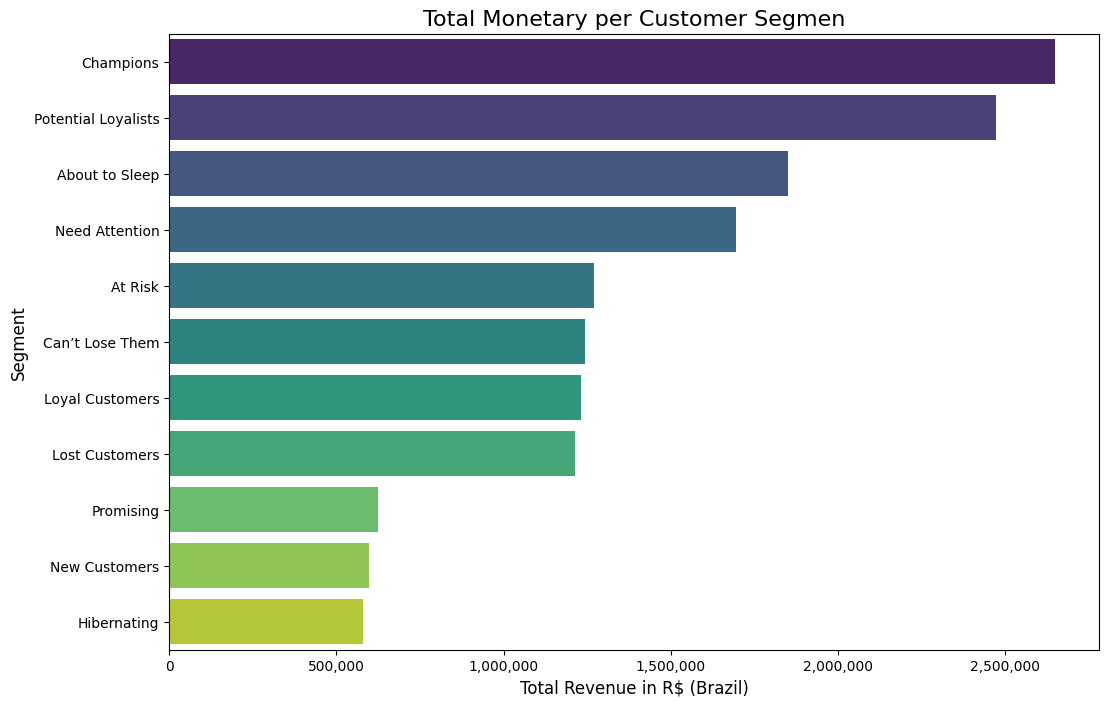

In [13]:
segment_analysis_sorted_monetary = segment_analysis.sort_values(by='total_monetary', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(
    data=segment_analysis_sorted_monetary,
    y='segment',
    x='total_monetary',
    palette='viridis'
)
plt.title('Total Monetary per Customer Segmen', fontsize=16)
plt.xlabel('Total Revenue in R$ (Brazil)', fontsize=12)
plt.ylabel('Segment', fontsize=12)
# Gunakan FuncFormatter untuk format angka
formatter = FuncFormatter(lambda x, p: format(int(x), ','))
plt.gca().xaxis.set_major_formatter(formatter)
plt.savefig('segment_monetary_value.png', bbox_inches='tight')
print("Visualization 'segment_monetary_value.png' saved.")

### Total Customer per Segment

Visualization 'segment_customer_count.png' saved.


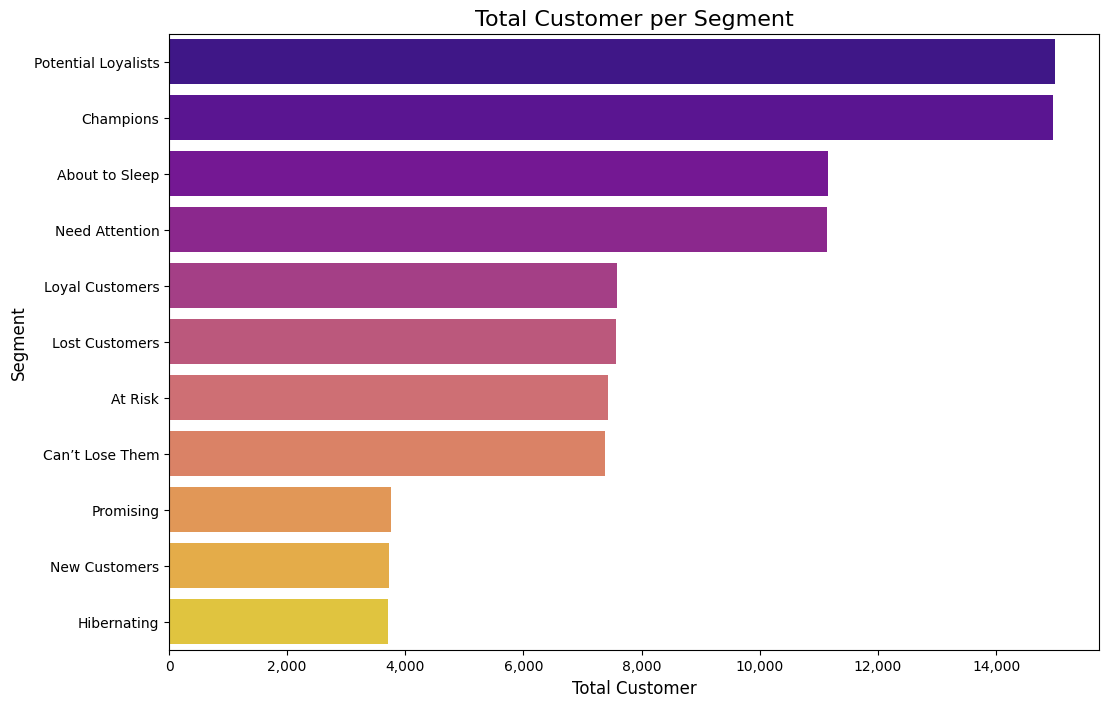

In [14]:
segment_analysis_sorted_count = segment_analysis.sort_values(by='customer_count', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(
    data=segment_analysis_sorted_count,
    y='segment',
    x='customer_count',
    palette='plasma'
)
plt.title('Total Customer per Segment', fontsize=16)
plt.xlabel('Total Customer', fontsize=12)
plt.ylabel('Segment', fontsize=12)
plt.gca().xaxis.set_major_formatter(formatter)
plt.savefig('segment_customer_count.png', bbox_inches='tight')
print("Visualization 'segment_customer_count.png' saved.")

In [15]:
print(segment_analysis.sort_values(by='total_monetary', ascending=False))

                segment  customer_count  total_monetary
3             Champions           14961      2647445.28
9   Potential Loyalists           14993      2472342.11
0        About to Sleep           11150      1849475.40
7        Need Attention           11130      1693651.61
1               At Risk            7427      1269025.70
2       Can’t Lose Them            7376      1242745.55
6       Loyal Customers            7579      1232315.87
5        Lost Customers            7559      1212437.96
10            Promising            3759       624714.83
8         New Customers            3720       598075.88
4           Hibernating            3703       580231.58


## K-Means Method

In [16]:
# take raw data
rfm_raw = rfm_df[['recency', 'frequency', 'monetary']]

# log for handling value 0
rfm_log = np.log1p(rfm_raw)

# standard scaling
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# dafaframe format
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=rfm_raw.columns, index=rfm_raw.index)

print("Data Raw:")
print(rfm_raw.head())
print("\nData After Scaling:")
print(rfm_scaled_df.head())

Data Raw:
   recency  frequency  monetary
0      112          1    141.90
1      115          1     27.19
2      537          1     86.22
3      321          1     43.62
4      288          1    196.89

Data After Scaling:
    recency  frequency  monetary
0 -0.470385  -0.170191  0.288235
1 -0.442302  -0.170191 -1.719767
2  1.202051  -0.170191 -0.322526
3  0.651914  -0.170191 -1.151681
4  0.536031  -0.170191  0.690987


Plot 'kmeans_elbow_plot.png' disimpan.


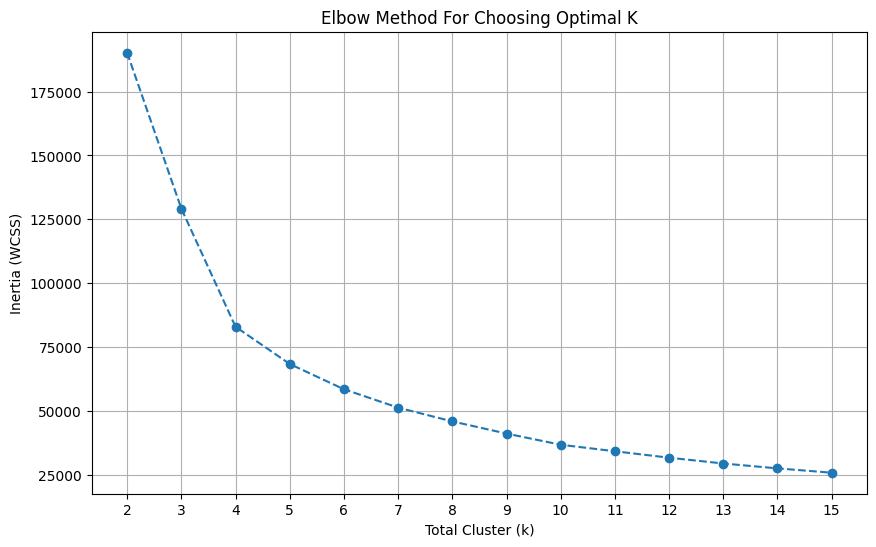

In [20]:
# show optimal K
inertia = []
K_range = range(2, 16)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(rfm_scaled_df)
    inertia.append(kmeans.inertia_)

# plot elbow method
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Total Cluster (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method For Choosing Optimal K')
plt.xticks(K_range)
plt.grid(True)
plt.savefig('kmeans_elbow_plot.png', bbox_inches='tight')
print("Plot 'kmeans_elbow_plot.png' disimpan.")

In [18]:
k_optimal = 11 

kmeans = KMeans(n_clusters=k_optimal, init='k-means++', n_init=10, random_state=42)
kmeans.fit(rfm_scaled_df)

# add label to cluster into DataFrame
rfm_df['cluster'] = kmeans.labels_

rfm_df.head()

,customer_unique_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,rf_score,segment,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,4,1,4,414,41,Promising,5
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,4,1,1,411,41,Promising,3
2,0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,112,11,Lost Customers,1
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,2,1,1,211,21,About to Sleep,8
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,4,214,21,About to Sleep,4


Average RFM per Cluster:
    cluster     recency  frequency    monetary
0         0   30.911468   1.000000  258.441356
1         1  336.896781   1.000000   95.941742
2         2  221.890789   2.000000  291.025410
3         3  141.391206   1.000000   44.810898
4         4  380.844056   1.000000  220.115126
5         5  109.288361   1.000000  102.026375
6         6   24.048040   1.000000   66.256357
7         7  259.746506   1.000000  811.565491
8         8  370.783427   1.000000   43.686661
9         9  153.879849   1.000000  214.585878
10       10  202.280702   3.399123  506.793114

Plot 'kmeans_snake_plot.png' saved.


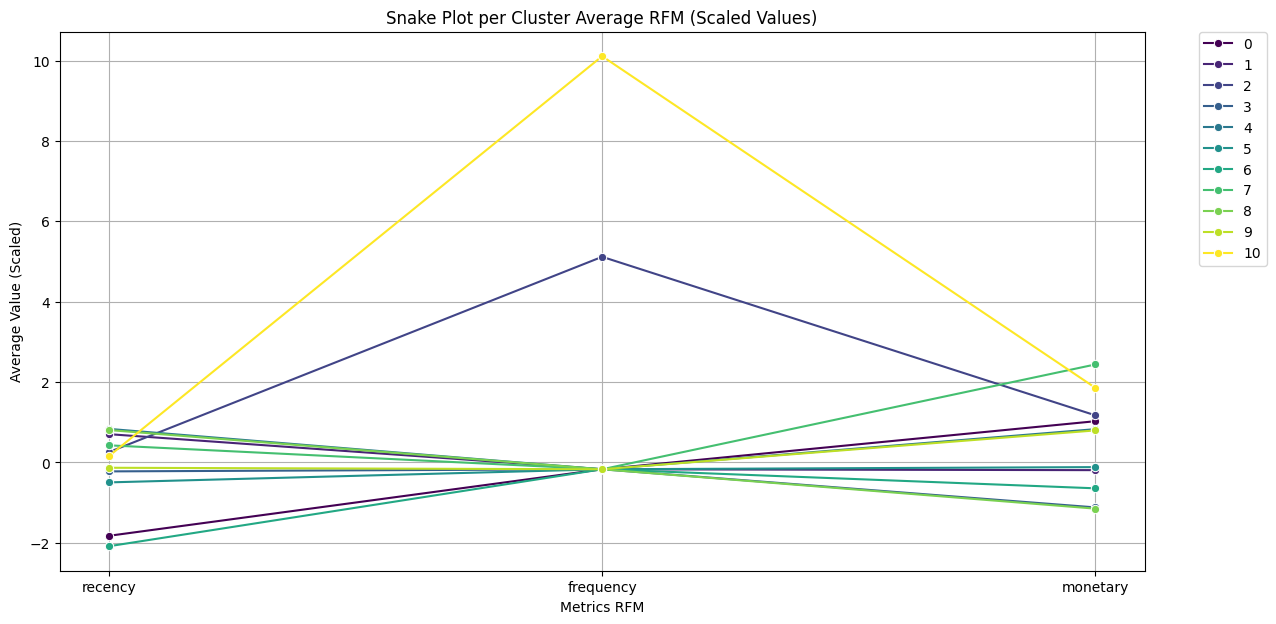

In [25]:
# analysis average rfm for each cluster
cluster_analysis = rfm_df.groupby('cluster')[['recency', 'frequency', 'monetary']].mean().reset_index()

print("Average RFM per Cluster:")
print(cluster_analysis)

cluster_analysis_avg = rfm_df.groupby('cluster')[['recency', 'frequency', 'monetary']].mean()
cluster_analysis_scaled_array = scaler.transform(np.log1p(cluster_analysis_avg)) 
cluster_analysis_scaled_df = pd.DataFrame(cluster_analysis_scaled_array, 
                                          columns=['recency', 'frequency', 'monetary'], 
                                          index=cluster_analysis_avg.index)

cluster_analysis_melted = cluster_analysis_scaled_df.reset_index().melt(id_vars='cluster', var_name='Metric', value_name='Scaled Value')

# snake plot
plt.figure(figsize=(14, 7))
sns.lineplot(data=cluster_analysis_melted, x='Metric', y='Scaled Value', hue='cluster', marker='o', palette='viridis', legend='full')
plt.title('Snake Plot per Cluster Average RFM (Scaled Values)')
plt.xlabel('Metrics RFM')
plt.ylabel('Average Value (Scaled)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.savefig('kmeans_snake_plot.png', bbox_inches='tight')
print("\nPlot 'kmeans_snake_plot.png' saved.")

In [26]:
# --- Peta Nama Cluster Berdasarkan Analisis Snake Plot ---
cluster_map = {
    10: 'K-Champions',              # R low, F very high, M high
    2:  'K-Can’t Lose Them',       # R high, F high, M high
    7:  'K-Potential Loyalists',   # R low, F low, M very high
    6:  'K-Need Attention (High Value)', # R med, F low, M high
    8:  'K-Loyal Customers',         # R low, F low, M med/high
    0:  'K-New Customers',           # R very low, F/M low
    3:  'K-Promising',               # R low, F/M low (similar to 0)
    4:  'K-Need Attention (Mid Value)',  # R med, F/M low
    5:  'K-About to Sleep',          # R med, F/M very low
    9:  'K-New (Low Value)',         # R low, F/M very low
    1:  'K-Lost Customers'           # R high, F/M low
}

rfm_df['k_segment'] = rfm_df['cluster'].map(cluster_map)

print("\nDataFrame for K-Means Segment:")
print(rfm_df.head())

# Save k-means result to separate CSV
rfm_df.to_csv("rfm_kmeans_segmentation.csv", index=False)
print("\nK-Means Result saved into 'rfm_kmeans_segmentation.csv'")


DataFrame for K-Means Segment:
                 customer_unique_id  recency  frequency  monetary r_score  \
0  0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90       4   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19       4   
2  0000f46a3911fa3c0805444483337064      537          1     86.22       1   
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62       2   
4  0004aac84e0df4da2b147fca70cf8255      288          1    196.89       2   

  f_score m_score rfm_score rf_score         segment  cluster  \
0       1       4       414       41       Promising        5   
1       1       1       411       41       Promising        3   
2       1       2       112       11  Lost Customers        1   
3       1       1       211       21  About to Sleep        8   
4       1       4       214       21  About to Sleep        4   

                      k_segment  
0              K-About to Sleep  
1                   K-Promising  
2           

## Visualization

Visualization 'k_segment_monetary_value.png' saved.
Visualization 'k_segment_customer_count.png' saved.


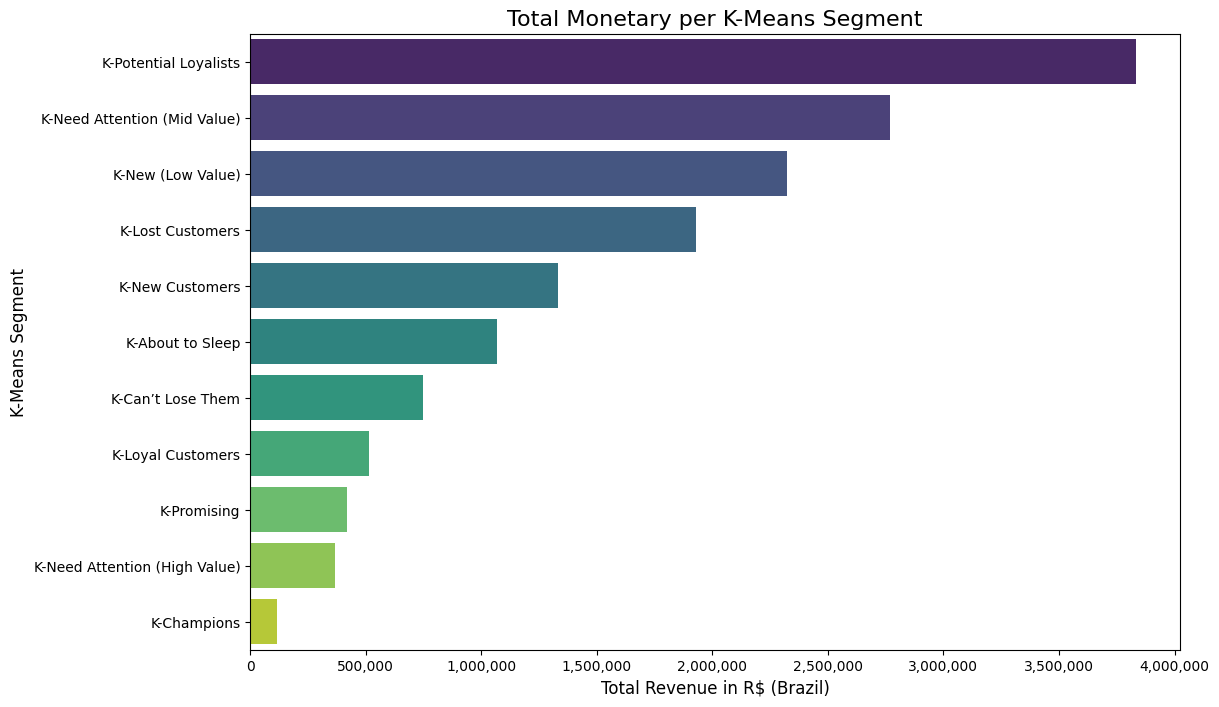

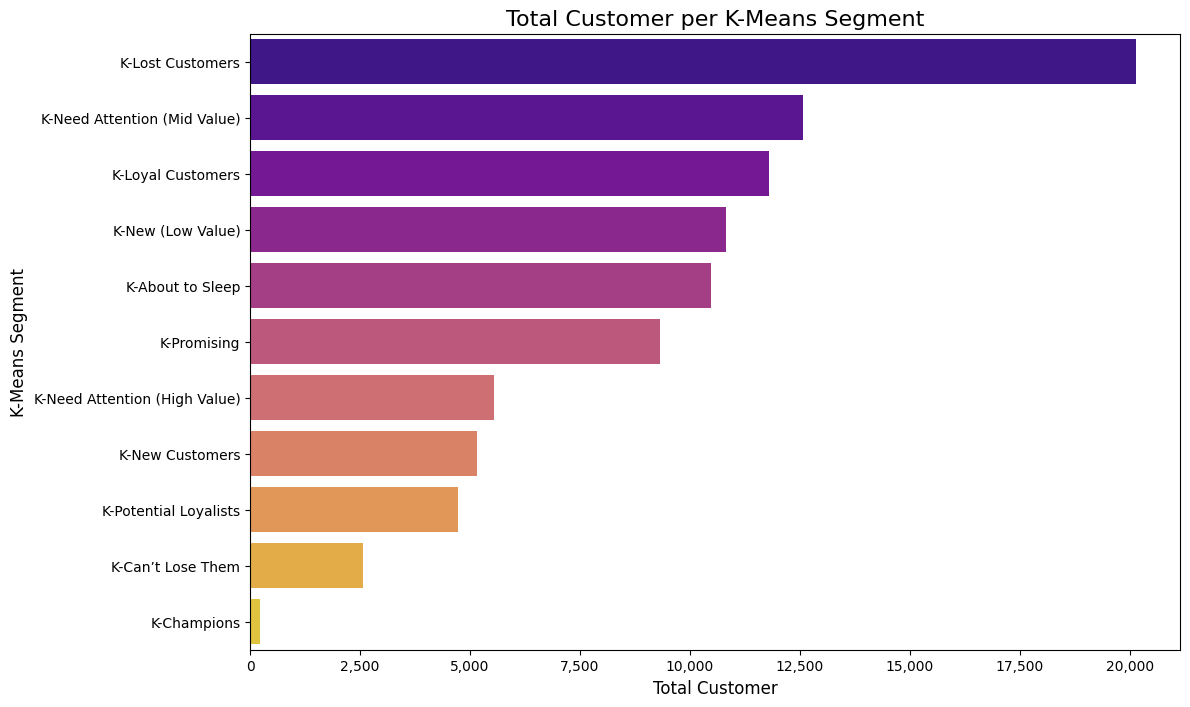

In [27]:
k_segment_analysis = rfm_df.groupby('k_segment').agg(
    customer_count=('customer_unique_id', 'count'),
    total_monetary=('monetary', 'sum')
).reset_index()

formatter = FuncFormatter(lambda x, p: format(int(x), ','))

# revenue per K-segment
k_segment_analysis_sorted_monetary = k_segment_analysis.sort_values(by='total_monetary', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(
    data=k_segment_analysis_sorted_monetary,
    y='k_segment',
    x='total_monetary',
    palette='viridis'
)
plt.title('Total Monetary per K-Means Segment', fontsize=16)
plt.xlabel('Total Revenue in R$ (Brazil)', fontsize=12)
plt.ylabel('K-Means Segment', fontsize=12)
plt.gca().xaxis.set_major_formatter(formatter)
plt.savefig('k_segment_monetary_value.png', bbox_inches='tight')
print("Visualization 'k_segment_monetary_value.png' saved.")


# total customer per K-segment
k_segment_analysis_sorted_count = k_segment_analysis.sort_values(by='customer_count', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(
    data=k_segment_analysis_sorted_count,
    y='k_segment',
    x='customer_count',
    palette='plasma'
)
plt.title('Total Customer per K-Means Segment', fontsize=16)
plt.xlabel('Total Customer', fontsize=12)
plt.ylabel('K-Means Segment', fontsize=12)
plt.gca().xaxis.set_major_formatter(formatter)
plt.savefig('k_segment_customer_count.png', bbox_inches='tight')
print("Visualization 'k_segment_customer_count.png' saved.")

## Compare results

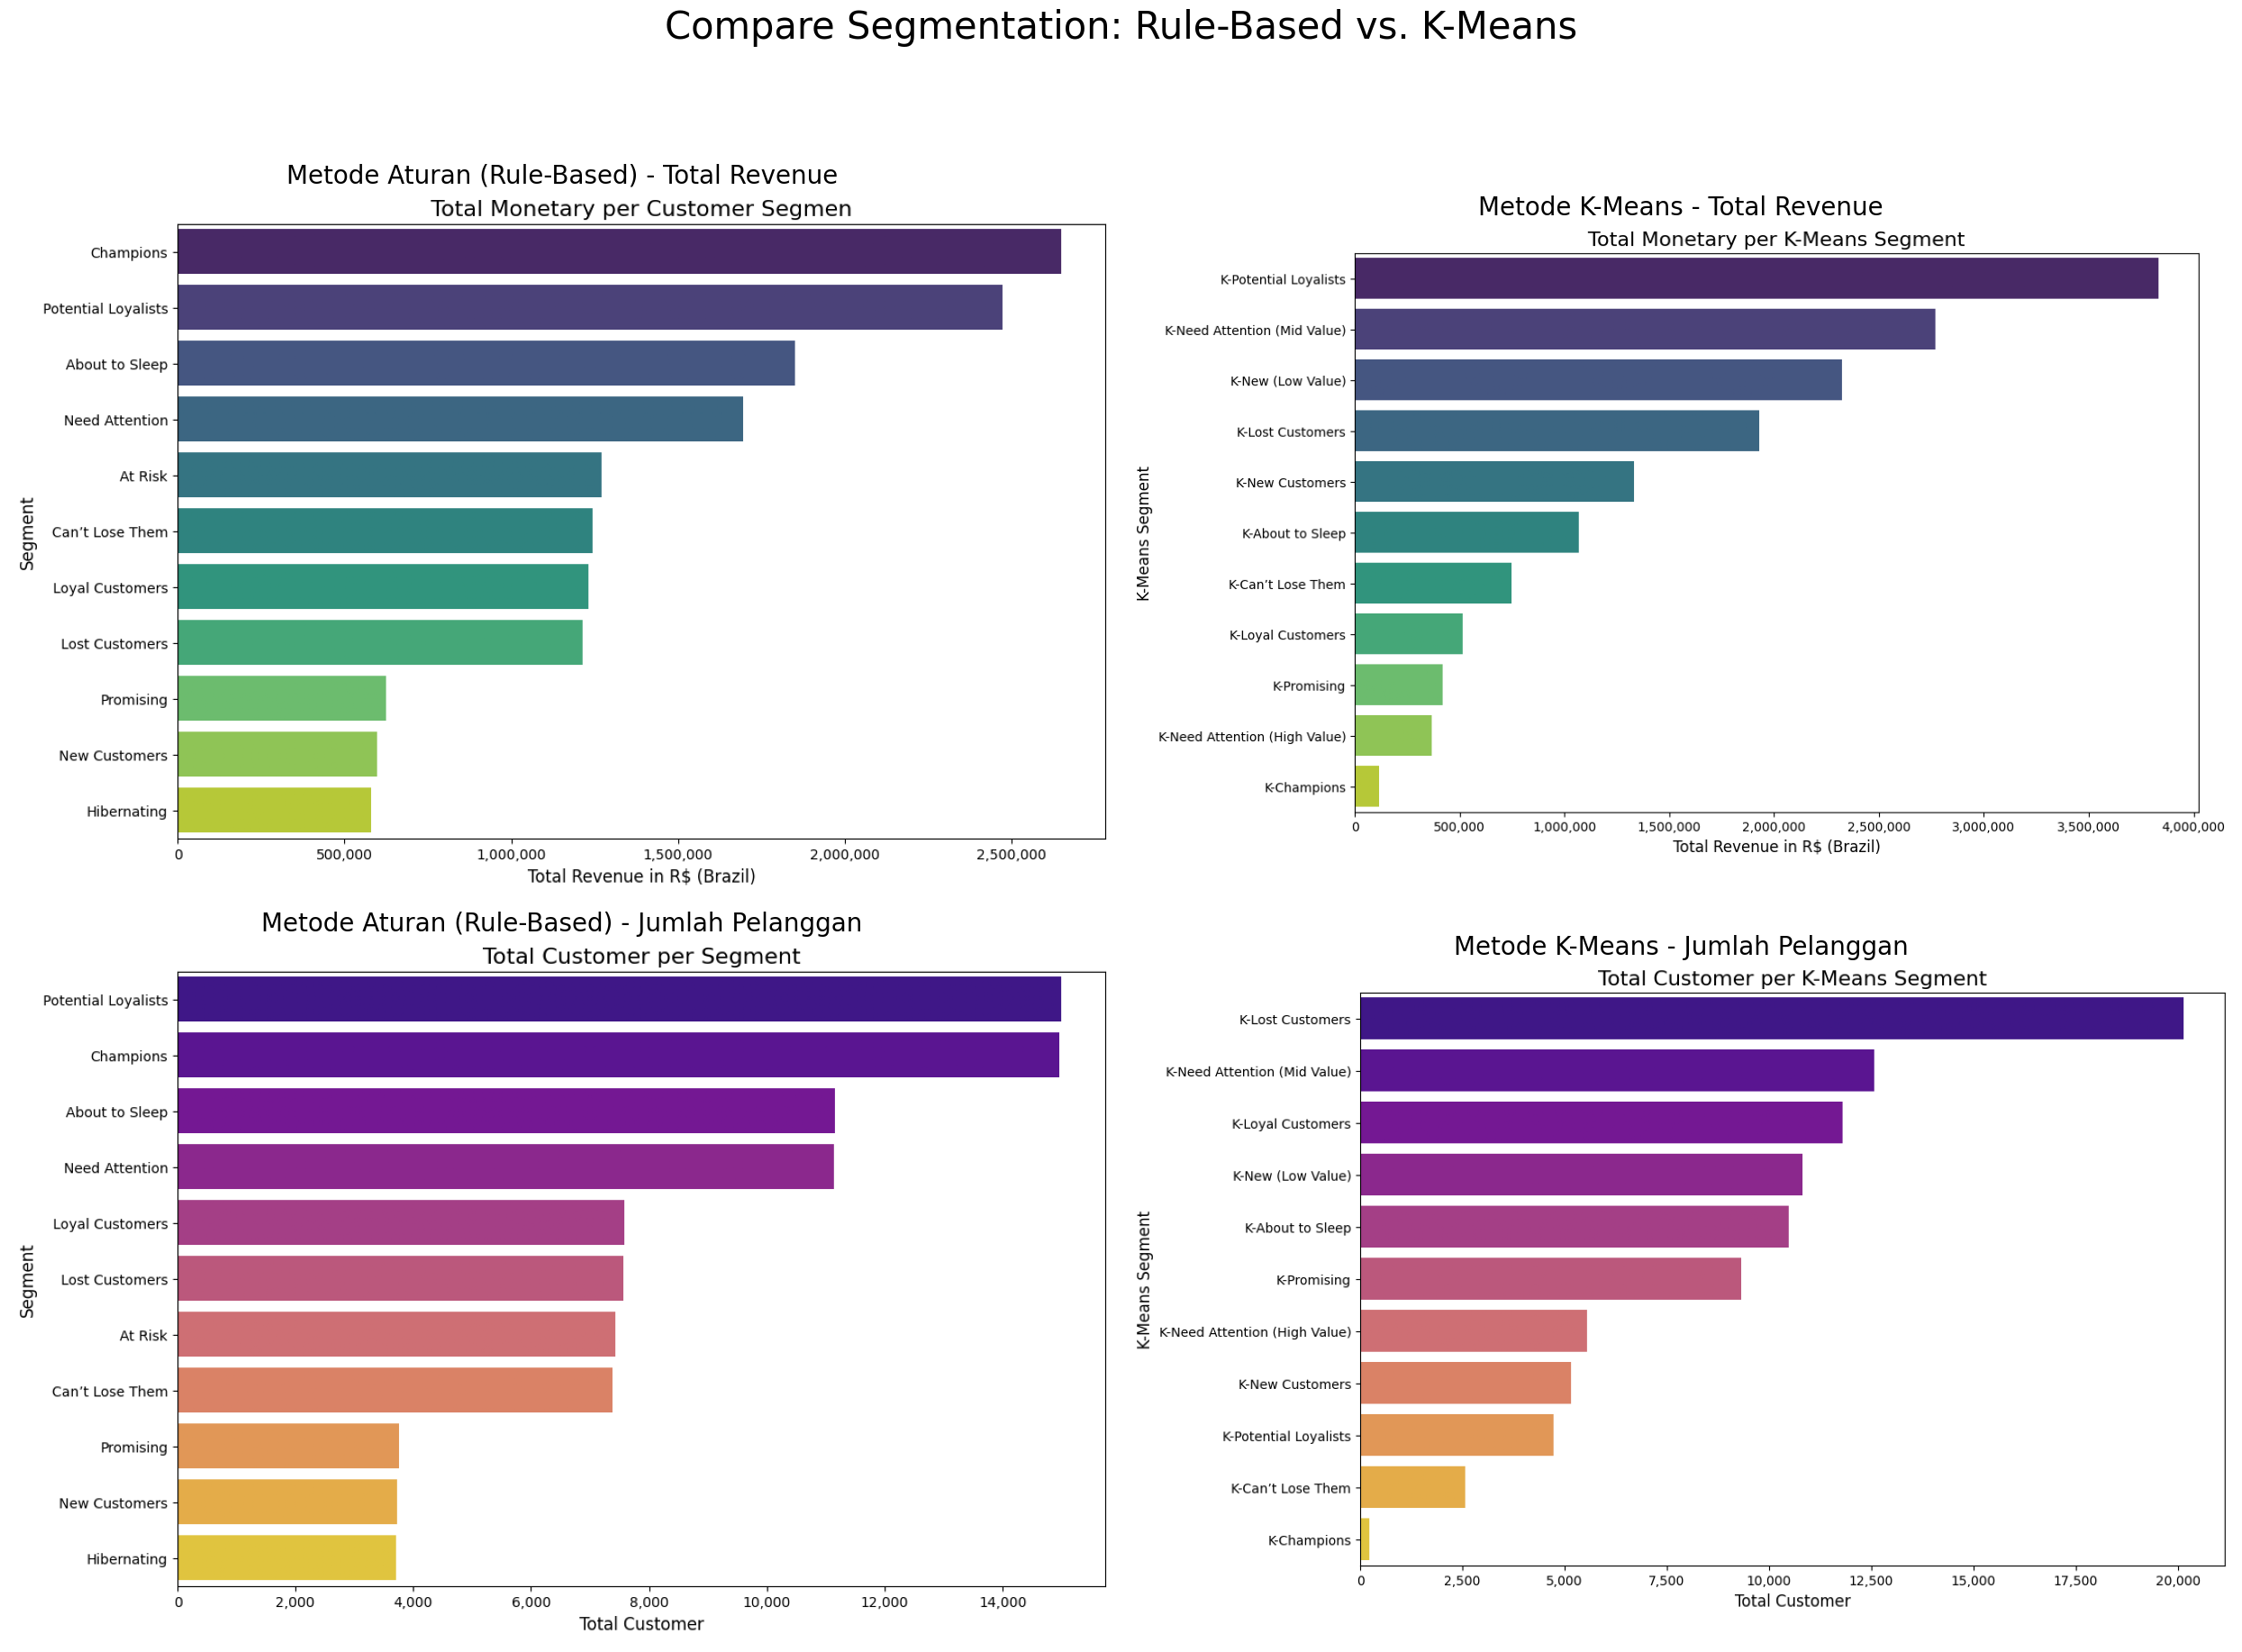

In [29]:
# compare result of the plot for both method
rule_monetary_img = 'segment_monetary_value.png'
kmeans_monetary_img = 'k_segment_monetary_value.png'
rule_count_img = 'segment_customer_count.png'
kmeans_count_img = 'k_segment_customer_count.png'

img_rm = mpimg.imread(rule_monetary_img)
img_km = mpimg.imread(kmeans_monetary_img)
img_rc = mpimg.imread(rule_count_img)
img_kc = mpimg.imread(kmeans_count_img)

fig, ax = plt.subplots(2, 2, figsize=(25, 20))

fig.suptitle('Compare Segmentation: Rule-Based vs. K-Means', fontsize=30)

ax[0, 0].imshow(img_rm)
ax[0, 0].set_title('Metode Aturan (Rule-Based) - Total Revenue', fontsize=20)
ax[0, 0].axis('off') # Sembunyikan sumbu (angka x dan y)


ax[0, 1].imshow(img_km)
ax[0, 1].set_title('Metode K-Means - Total Revenue', fontsize=20)
ax[0, 1].axis('off')

ax[1, 0].imshow(img_rc)
ax[1, 0].set_title('Metode Aturan (Rule-Based) - Jumlah Pelanggan', fontsize=20)
ax[1, 0].axis('off')

ax[1, 1].imshow(img_kc)
ax[1, 1].set_title('Metode K-Means - Jumlah Pelanggan', fontsize=20)
ax[1, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Atur layout agar pas
plt.show()

mostly our frequency of buyer is 1 which mean that the quantile (rule-based) is having problem. We seperate the data based on frequency based on 5 group (quantiles). And 90% of it have the same value which is 1. With adding .rank(method='first) we forcing *Pandas* to randomly ranking all identical customer
- Customer A (frequency=1) can resulting f_score = 1
- Customer B (frequency=1) can resulting f_score = 3
- Customer C (frequency=1) can resulting f_score = 5

even though they have same behaviour

And why K-means is telling the truth?
Total customer per K-means segment around ~500 people and lost customer around ~20.000 people
that's more realistic 
In total monetary per K-means segment showing K-champions revenue is the smallest in total and k-potential loyalist giving revenue the biggest (~3.8 mil)  